<a href="https://colab.research.google.com/github/DavidkingMazimpaka/NutriGuard_Mission_Capstone/blob/main/malnutrition_model_training_evaluation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load datasets
df = pd.read_excel("/content/drive/MyDrive/ALU Final year ML/NutriGuard Mission Capstone/datasets/NutriGuardDataset.xlsx")

## Initial Data Loading and Exploration:

(837, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sex                               837 non-null    int64  
 1   Age                               837 non-null    int64  
 2   Height                            837 non-null    int64  
 3   Weight                            837 non-null    int64  
 4   Status                            837 non-null    object 
 5   Height-for-age (Mean Z-score)     837 non-null    float64
 6   Weight-for-height (Mean Z-score)  837 non-null    float64
 7   Weight-for-age (Mean Z-score)     837 non-null    float64
 8   Height_m                          837 non-null    float64
 9   BMI                               837 non-null    float64
 10  WHR                               837 non-null    float64
dtypes: float64(6), int64(4), object(1)
memory usage: 72.1+ KB
Non

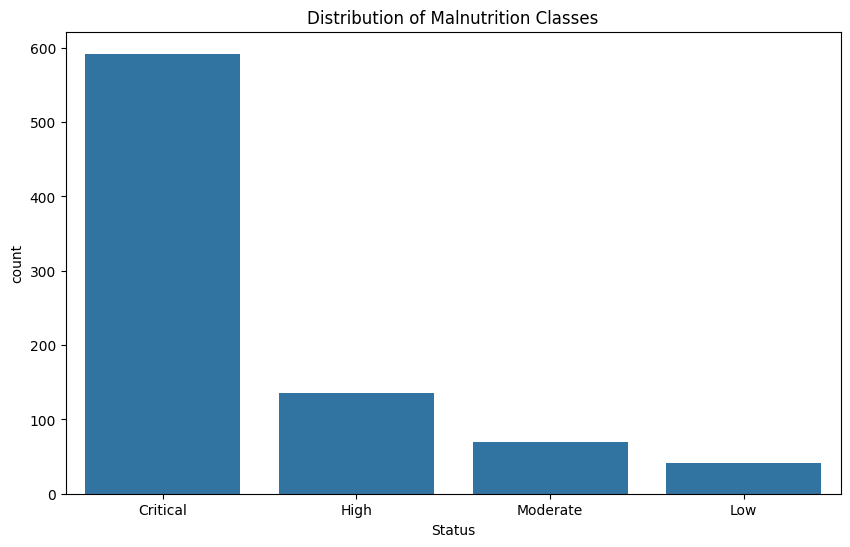

In [8]:
# Basic exploration
print(df.shape)
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Encode the Status column
le = LabelEncoder()
df['Status_encoded'] = le.fit_transform(df['Status'])
# This will map your classes (Low, Moderate, High, Critical) to numeric values

# Check class distribution
print(df['Status'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(x='Status', data=df)
plt.title('Distribution of Malnutrition Classes')
plt.show()

## Exploratory Data Analysis with Focus on Class Distinctions:

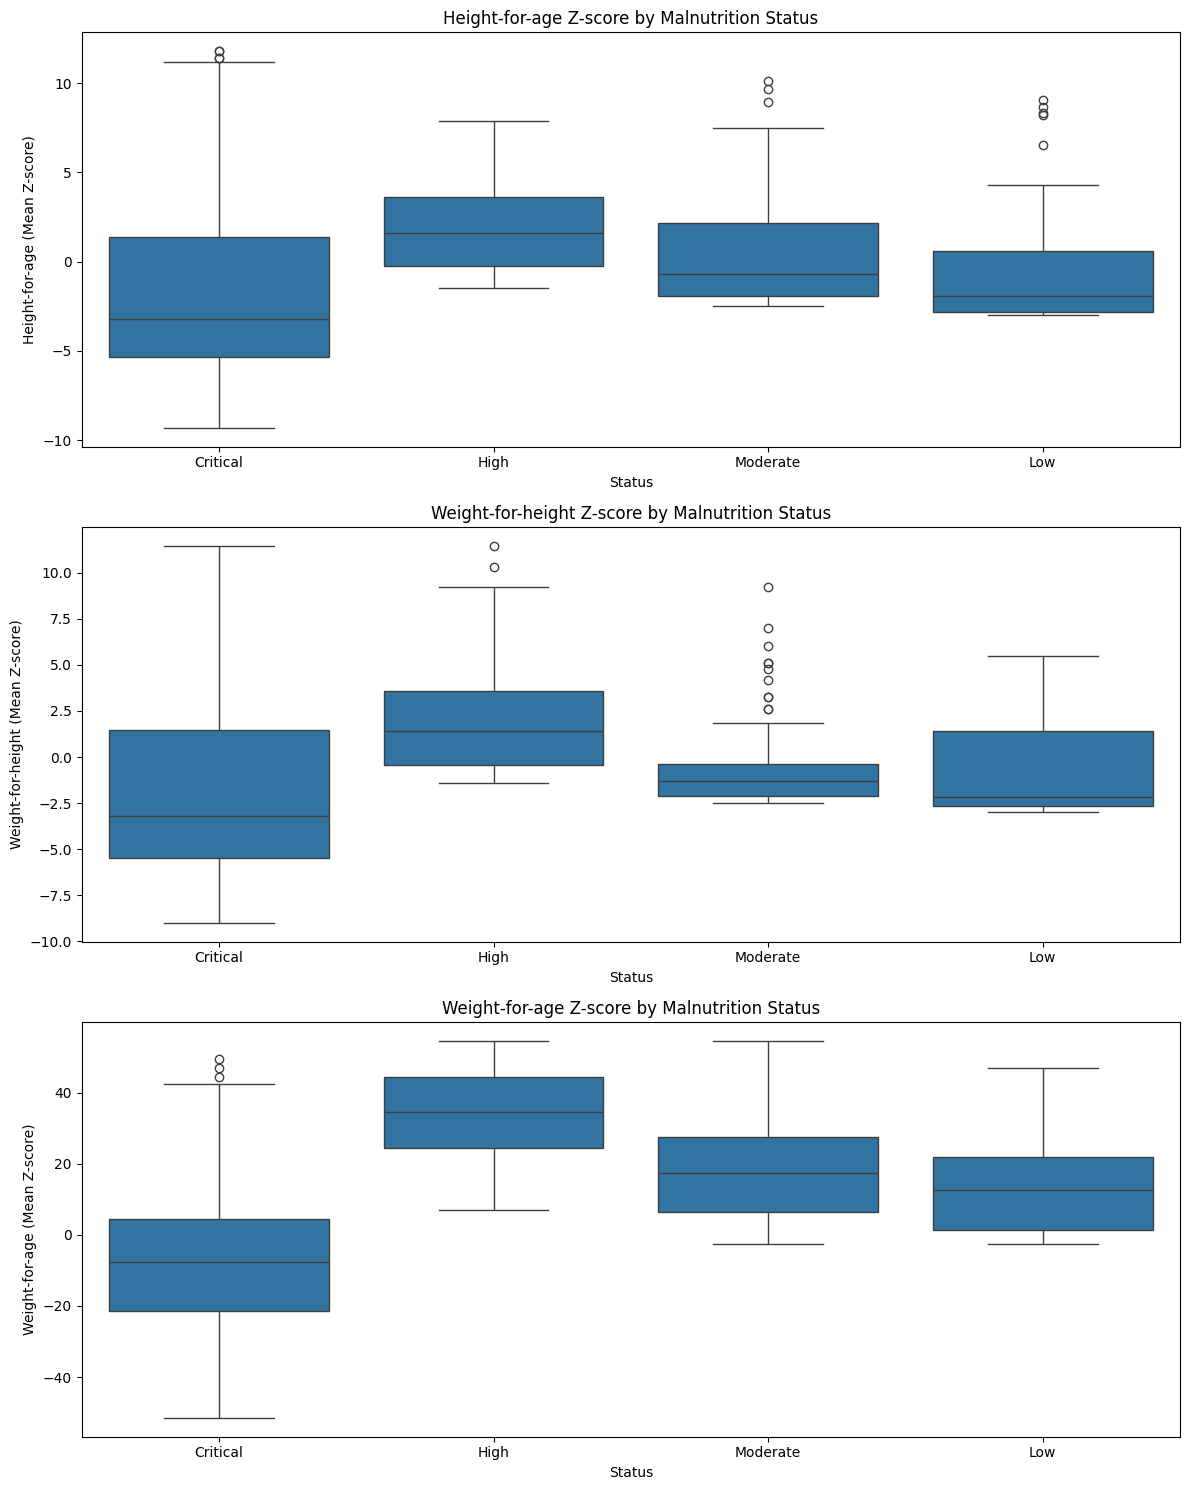

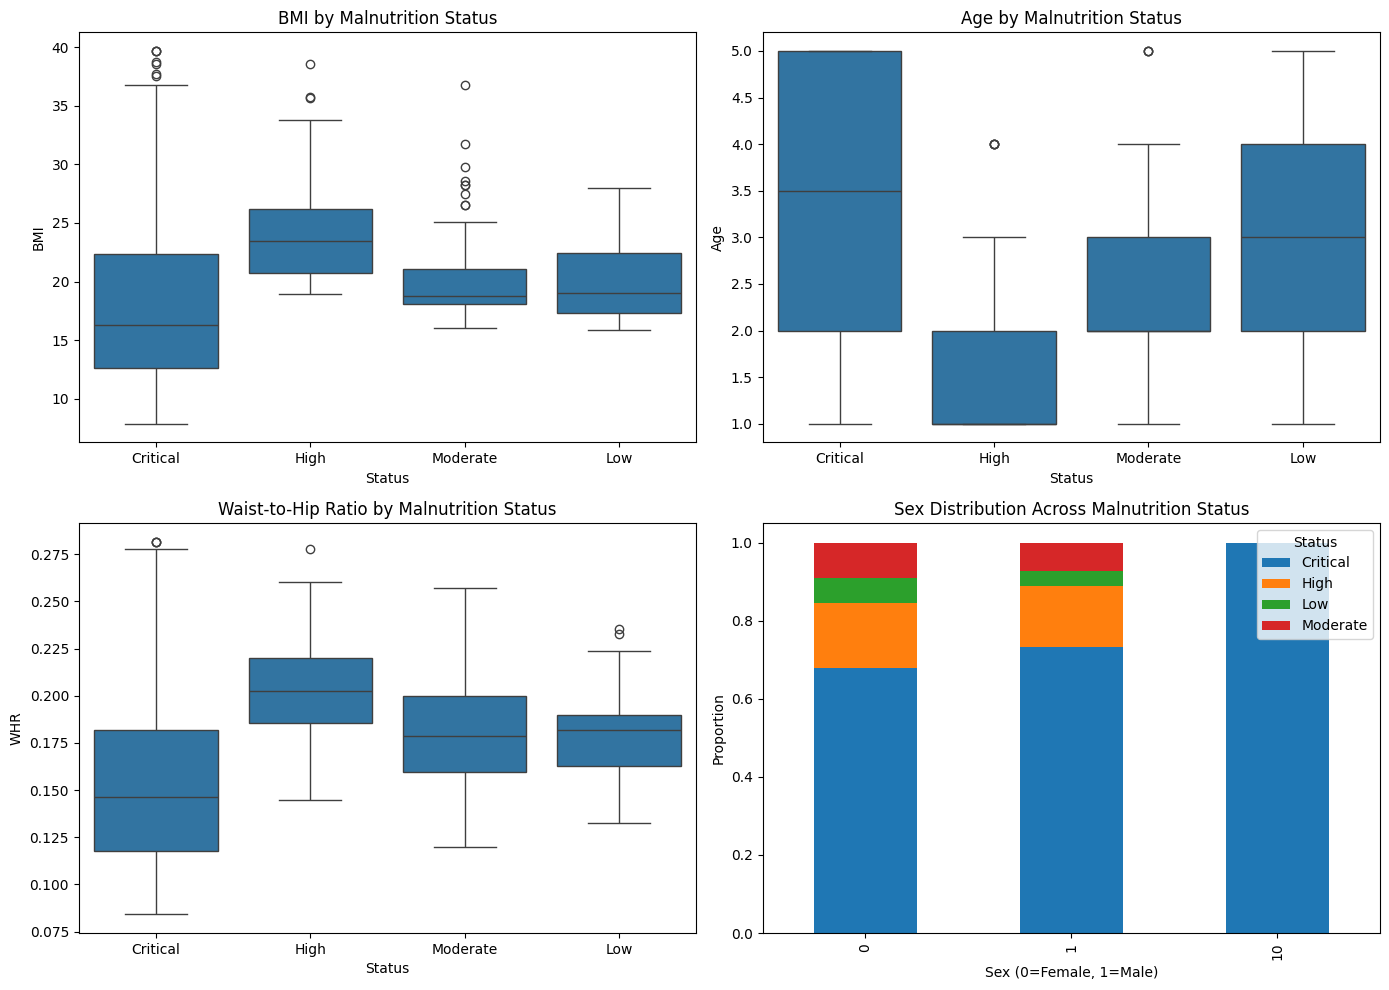

In [9]:
# Let's understand how features differ across malnutrition classes

# Z-score distributions by class
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
sns.boxplot(x='Status', y='Height-for-age (Mean Z-score)', data=df, ax=axes[0])
axes[0].set_title('Height-for-age Z-score by Malnutrition Status')

sns.boxplot(x='Status', y='Weight-for-height (Mean Z-score)', data=df, ax=axes[1])
axes[1].set_title('Weight-for-height Z-score by Malnutrition Status')

sns.boxplot(x='Status', y='Weight-for-age (Mean Z-score)', data=df, ax=axes[2])
axes[2].set_title('Weight-for-age Z-score by Malnutrition Status')
plt.tight_layout()
plt.show()

# Other key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.boxplot(x='Status', y='BMI', data=df, ax=axes[0, 0])
axes[0, 0].set_title('BMI by Malnutrition Status')

sns.boxplot(x='Status', y='Age', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Age by Malnutrition Status')

sns.boxplot(x='Status', y='WHR', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Waist-to-Hip Ratio by Malnutrition Status')

# Distribution of Sex by Status
sex_status = pd.crosstab(df['Sex'], df['Status'], normalize='index')
sex_status.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Sex Distribution Across Malnutrition Status')
axes[1, 1].set_xlabel('Sex (0=Female, 1=Male)')
axes[1, 1].set_ylabel('Proportion')
plt.tight_layout()
plt.show()

## Address Class imbalance with SMOTE & Reduce Overfitting with cross-Validation

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Prepare features and target
X = df.drop(['Status', 'Status_encoded'], axis=1)
y = df['Status_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a preprocessing pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=5)),  # Adjust k_neighbors here
    ('classifier', RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=5))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Check the new class distribution after resampling
X_train_resampled, y_train_resampled = pipeline.named_steps['smote'].fit_resample(X_train, y_train)

print("Original training set class distribution:")
print(pd.Series(y_train).value_counts())
print("\nResampled training set class distribution:")
print(pd.Series(y_train_resampled).value_counts())

# Evaluate using cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
print("Cross-validated F1 Score:", scores.mean())

Original training set class distribution:
Status_encoded
0    473
1    108
3     55
2     33
Name: count, dtype: int64

Resampled training set class distribution:
Status_encoded
0    473
1    473
2    473
3    473
Name: count, dtype: int64
Cross-validated F1 Score: 0.9772330998886354


In [16]:
# Check how the label encoder mapped your classes
print("Label mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")

Label mapping:
Critical -> 0
High -> 1
Low -> 2
Moderate -> 3


## Model Training with Class Imbalance Handling


--------------------------------------------------
Evaluating Random Forest
--------------------------------------------------
Balanced Accuracy: 0.9481
Macro F1-Score: 0.9404
Weighted F1-Score: 0.9764

Classification Report:
              precision    recall  f1-score   support

    Critical       0.99      0.99      0.99       119
        High       1.00      0.93      0.96        27
    Moderate       0.88      0.88      0.88         8
         Low       0.88      1.00      0.93        14

    accuracy                           0.98       168
   macro avg       0.94      0.95      0.94       168
weighted avg       0.98      0.98      0.98       168



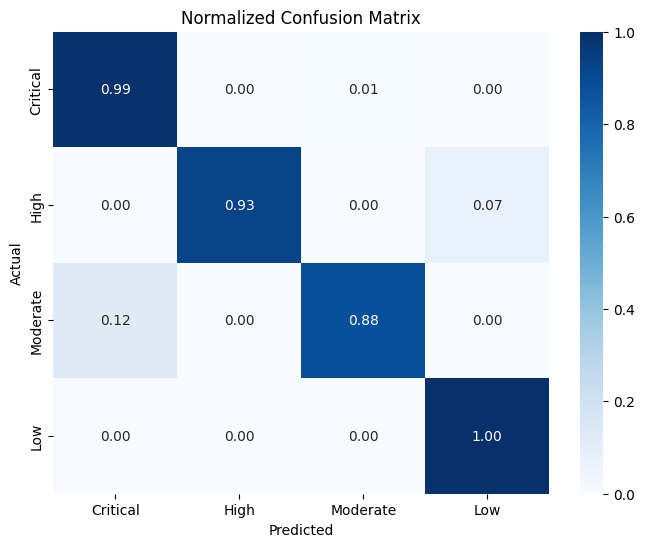


--------------------------------------------------
Evaluating XGBoost
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:56:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Balanced Accuracy: 0.8833
Macro F1-Score: 0.8981
Weighted F1-Score: 0.9636

Classification Report:
              precision    recall  f1-score   support

    Critical       0.98      1.00      0.99       119
        High       0.96      0.93      0.94        27
    Moderate       0.86      0.75      0.80         8
         Low       0.86      0.86      0.86        14

    accuracy                           0.96       168
   macro avg       0.91      0.88      0.90       168
weighted avg       0.96      0.96      0.96       168



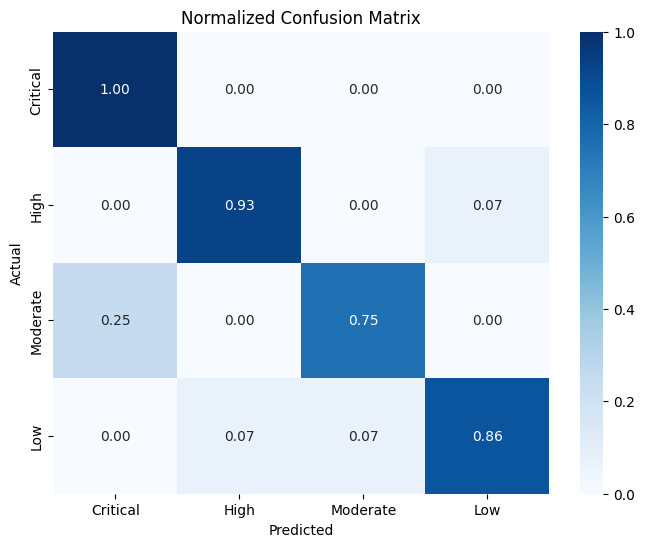


--------------------------------------------------
Evaluating LightGBM
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 1892, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

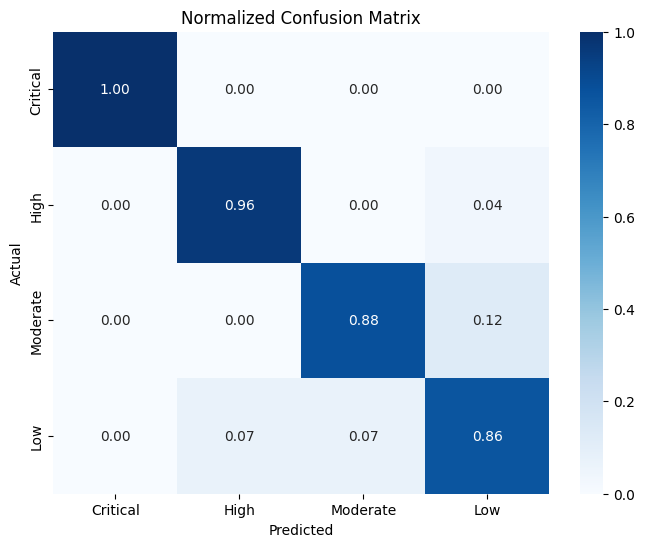

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score

# Function to evaluate models with appropriate metrics for imbalanced data
def evaluate_imbalanced_model(model, X_train, X_test, y_train, y_test, class_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"Macro F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Weighted F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    return model

# Define models with imbalance-aware parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        scale_pos_weight=[5, 2, 1, 1],  # Approximate weights based on class distribution
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        class_weight='balanced',
        random_state=42
    )
}

results = {}
class_names = ['Critical', 'High', 'Moderate', 'Low']  # Adjust order if needed to match encoding
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Evaluating {name}")
    print(f"{'-'*50}")
    results[name] = evaluate_imbalanced_model(
        model, X_train_resampled, X_test, y_train_resampled, y_test, class_names
    )

## Feature Importance Analysis


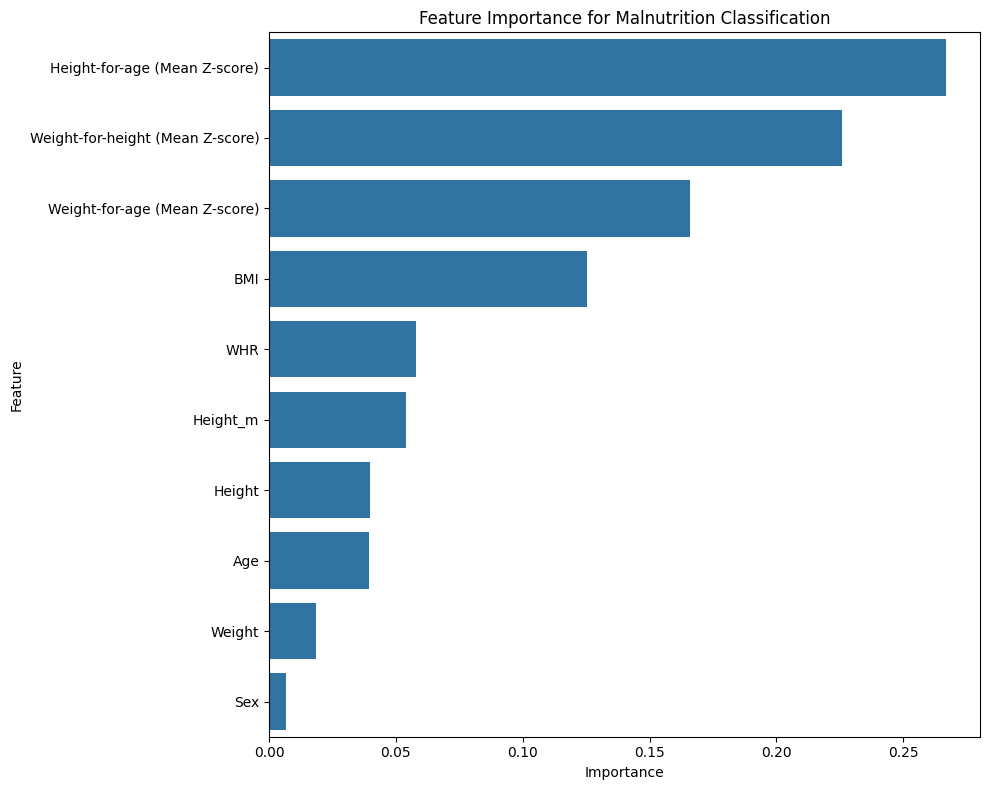

Top 5 most important features:
                            Feature  Importance
4     Height-for-age (Mean Z-score)    0.266887
5  Weight-for-height (Mean Z-score)    0.225703
6     Weight-for-age (Mean Z-score)    0.165798
8                               BMI    0.125517
9                               WHR    0.057737


In [18]:
# Get feature importance from the best model (assuming Random Forest for this example)
best_model = results['Random Forest']  # Change to whichever model performed best

if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Feature Importance for Malnutrition Classification')
    plt.tight_layout()
    plt.show()

    print("Top 5 most important features:")
    print(importance.head(5))

## Hyperparameter Tunning with Imbalanced Data Focus

Best parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best macro F1 score: 0.9868
Balanced Accuracy: 0.9011
Macro F1-Score: 0.9124
Weighted F1-Score: 0.9698

Classification Report:
              precision    recall  f1-score   support

    Critical       0.98      1.00      0.99       119
        High       1.00      0.93      0.96        27
    Moderate       0.86      0.75      0.80         8
         Low       0.87      0.93      0.90        14

    accuracy                           0.97       168
   macro avg       0.93      0.90      0.91       168
weighted avg       0.97      0.97      0.97       168



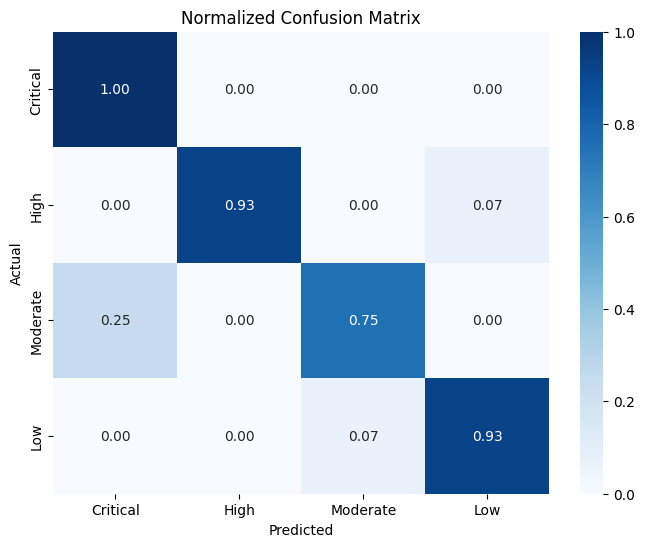

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Assuming XGBoost performed well
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Use randomized search for efficiency with many parameters
random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    scoring='f1_macro',  # Focus on macro F1 score for imbalanced classes
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best macro F1 score: {random_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
evaluate_imbalanced_model(best_model, X_train_resampled, X_test,
                         y_train_resampled, y_test, class_names)

## Final Model Evaluation

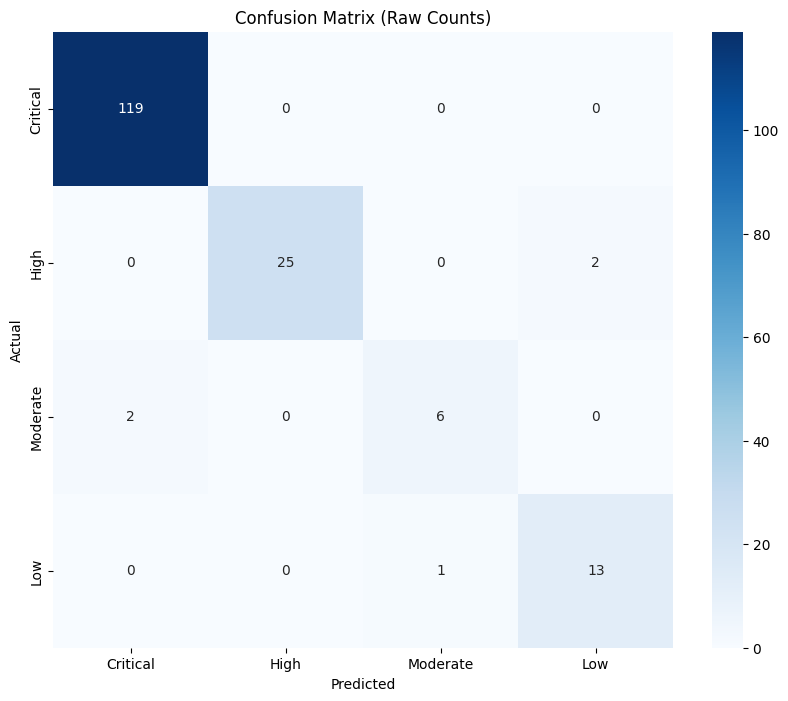

              precision    recall  f1-score     support
Critical       0.983471  1.000000  0.991667  119.000000
High           1.000000  0.925926  0.961538   27.000000
Moderate       0.857143  0.750000  0.800000    8.000000
Low            0.866667  0.928571  0.896552   14.000000
accuracy       0.970238  0.970238  0.970238    0.970238
macro avg      0.926820  0.901124  0.912439  168.000000
weighted avg   0.970378  0.970238  0.969771  168.000000
Number of misclassified samples: 5

Types of misclassifications:
Predicted  Critical  Low  Moderate
Actual                            
High              0    2         0
Low               0    0         1
Moderate          2    0         0


In [21]:
# Confusion matrix with raw counts (not normalized)
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Raw Counts)')
plt.show()

# Per-class performance analysis
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
class_metrics = pd.DataFrame(report).transpose()
print(class_metrics)

# Examine error cases in more detail
X_test_with_results = X_test.copy()
X_test_with_results['Actual'] = [class_names[i] for i in y_test]
X_test_with_results['Predicted'] = [class_names[i] for i in y_pred]
X_test_with_results['Correct'] = X_test_with_results['Actual'] == X_test_with_results['Predicted']

# Look at misclassified samples
misclassified = X_test_with_results[~X_test_with_results['Correct']]
print(f"Number of misclassified samples: {len(misclassified)}")

# Summary of types of errors
error_types = pd.crosstab(
    misclassified['Actual'],
    misclassified['Predicted'],
    rownames=['Actual'],
    colnames=['Predicted']
)
print("\nTypes of misclassifications:")
print(error_types)

## Saving the model

In [22]:
import pickle
import joblib
import os

# Create a directory to store model artifacts if it doesn't exist
os.makedirs('model_artifacts', exist_ok=True)

# 1. Save the trained model using joblib (better for scikit-learn models)
joblib.dump(best_model, 'model_artifacts/malnutrition_rf_model.joblib')

# 2. Save class names for interpretation
with open('model_artifacts/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

# 3. Save feature names to ensure correct order during prediction
# If your feature names are in a variable called feature_names
# If not, you can extract them from X_test
feature_names = X_test.columns.tolist()
# Remove any non-feature columns you added during evaluation
for col in ['Actual', 'Predicted', 'Correct']:
    if col in feature_names:
        feature_names.remove(col)

with open('model_artifacts/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# 4. If you used any preprocessing transformers (like scalers, encoders, etc.)
# Make sure to save those too
# For example:
# joblib.dump(scaler, 'model_artifacts/scaler.joblib')
# joblib.dump(encoder, 'model_artifacts/encoder.joblib')

# 5. Create a simple metadata file with model information
import json
model_metadata = {
    'model_type': 'RandomForest',
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'accuracy': report['accuracy'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_f1': report['weighted avg']['f1-score'],
    'class_mapping': {i: name for i, name in enumerate(class_names)},
    'feature_count': len(feature_names),
    'malnutrition_classes': len(class_names)
}

with open('model_artifacts/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f)

print("Model and associated artifacts saved successfully!")

Model and associated artifacts saved successfully!


In [23]:
import os
import zipfile
import shutil

def create_artifacts_zip():
    """
    Creates a zip file of all model artifacts for easy download
    """
    # Path to artifacts directory
    artifacts_dir = 'model_artifacts'

    # Name of the zip file
    zip_filename = 'malnutrition_model_artifacts.zip'

    # Check if artifacts directory exists
    if not os.path.exists(artifacts_dir):
        print(f"Error: {artifacts_dir} directory not found!")
        return None

    try:
        # Create zip file
        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add all files from the artifacts directory
            for root, _, files in os.walk(artifacts_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Add file to zip with a path relative to artifacts_dir
                    arcname = os.path.relpath(file_path, start=os.path.dirname(artifacts_dir))
                    zipf.write(file_path, arcname=arcname)

        print(f"Successfully created {zip_filename}")

        # If you're in a notebook environment, you can also provide download code
        try:
            from google.colab import files
            files.download(zip_filename)
            print("Download initiated in Colab")
        except ImportError:
            print(f"Zip file created at: {os.path.abspath(zip_filename)}")

    except Exception as e:
        print(f"Error creating zip file: {e}")

# Call the function to create and download the zip
create_artifacts_zip()

Successfully created malnutrition_model_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated in Colab
